In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import OxfordIIITPet
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchinfo import summary

import math
import random
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [2]:
# Computes scaled dot-product attention with an optional mask
# Images don't need the mask
def calculate_masked_attention(
    values: torch.Tensor,
    keys: torch.Tensor,
    query: torch.Tensor,
    mask: torch.Tensor = None,
):
    # Dot product (I think is done by inner product because Keys transposed)
    attention_scores = torch.matmul(query, keys.transpose(-2, -1))
    
    # Divides out sqrt(d_k)
    attention_scores = attention_scores / math.sqrt(keys.shape[-1])
    
    # If provided a mask, sets all 0's to be -infinity so softmax zeroes them out
    if mask is not None:
        attention_scores = torch.where(mask == 0, -1e9, attention_scores)
    attention_scores = F.softmax(attention_scores, dim=-1)
    
    # multiply values by weights to get deltaE vectors
    attention = torch.matmul(attention_scores, values)
    return attention, attention_scores

In [3]:
class FeedForward(nn.Module):
    def __init__(self, embed_size: int):
        super().__init__()
        self.layer1 = nn.Linear(embed_size, embed_size)
        self.layer2 = nn.Linear(embed_size, embed_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = F.gelu(x)
        x = self.layer2(x)
        return x
    
class AttentionLayer(nn.Module):
    def __init__(self, embed_size: int):
        super().__init__()
        self.embed_size = embed_size
        self.query_dense = nn.Linear(embed_size, embed_size)
        self.key_dense = nn.Linear(embed_size, embed_size)
        self.value_dense = nn.Linear(embed_size, embed_size)

    def forward(self, embeddings: torch.Tensor):
        query = self.query_dense(embeddings)
        key = self.key_dense(embeddings)
        value = self.value_dense(embeddings)
        attention, attention_scores = calculate_masked_attention(value, key, query, None)
        return attention, attention_scores



In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size: int):
        super().__init__()
        self.attention_layer = AttentionLayer(embed_size)
        self.feed_forward = FeedForward(embed_size)
        self.layer_normal = nn.LayerNorm(embed_size)

    def forward(self, x: torch.Tensor):
        context, attention_scores = self.attention_layer(x)
        context = self.layer_normal(context)
        context = self.feed_forward(context)
        output = context + x # Residual connection I think
        output = F.gelu(output) 
        return output, attention_scores
        

#        context = F.gelu(context) 
#        output = context + x # Residual connection I think


class Transformer(nn.Module):
    def __init__(self, embed_size: int, num_layers: int):
        super().__init__()
        self.transformer_blocks = nn.ModuleList(TransformerBlock(embed_size) for _ in range(num_layers))

    def forward(self, x: torch.Tensor):
        attention_scores = []
        for transformer_block in self.transformer_blocks:
            x, attention_score = transformer_block(x)
            attention_scores.append(attention_score)
        return x, attention_scores
    
class SinusoidalPositionEncoding(nn.Module):
    def __init__(self, embed_size: int, max_seq_length: int):
        super().__init__()
        position = torch.arange(max_seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2) * (-math.log(10000.0) / embed_size))
        pe = torch.zeros(max_seq_length, embed_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term) 
        self.register_buffer('positional_embedding', pe)

    def forward(self, x: torch.Tensor):
        return x + self.positional_embedding[:x.size(1), :]


In [5]:
class VisionTransformer(nn.Module):
    def __init__(
            self,
            image_size,
            patch_size,
            num_channels,
            embed_size,
            num_layers,
    ):
        super(VisionTransformer, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        assert (
            image_size % patch_size == 0
        ), "Image size must be divisible by patch size!"
        self.num_patches = (image_size // patch_size) ** 2
        max_len = self.num_patches + 1

        # Patch embedding
        self.positional_encoding = SinusoidalPositionEncoding(embed_size, max_seq_length=max_len)

        # does splitting ? patches the input
        self.patch_embed = nn.Conv2d(
            num_channels, embed_size, kernel_size=patch_size, stride=patch_size
        )

        # Make classification token, random initially
        self.cls_token_index = 0
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))


        # Remove positional embedding from here
        self.transformer = Transformer(embed_size, num_layers)

    def forward(self, image, return_attention=False):
        #image shape: (batch_size, num_channels, height, width)
        batch_size = image.shape[0]

        # Patch embedding
        x = self.patch_embed(image) # (batch_size, num_channels, h', w')  DOUBLE CHECK THESE DIM
        x = x.flatten(2).transpose(1, 2) # (batch_size, num_patches, embed_size)
        
        # Add class token
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_token, x), dim = 1)
        x = self.positional_encoding(x)
        # Pass through transformer 
        x, attention_maps = self.transformer(x)
        if return_attention:
            return x, attention_maps
        else : 
            return x

In [6]:
class VITClassifier(nn.Module):
    def __init__(self, image_size, patch_size, num_channels, embed_size, num_layers, num_classes):
        super().__init__()
        self.vit = VisionTransformer(image_size, patch_size, num_channels, embed_size, num_layers)
        
        # maps the cls_token to the number of classes
        self.linear = nn.Linear(embed_size, num_classes)

    def forward(self, x: torch.Tensor):
        x = self.vit(x)
        return self.linear(x[:, 0, :])
    

In [ ]:
def get_mnist_dataset(image_size=28, batch_size=32):

    # Redundant resizing since images are already 28x28
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    train_set = MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Gets train and test samples from MNIST with batch size overridden to 256
train_loader, test_loader = get_mnist_dataset(batch_size=256)

In [8]:
# initialize model
vit = VITClassifier(image_size=28, patch_size=4, num_channels=1, embed_size=16, num_layers=4, num_classes=10).to(device)

summary(vit)

Layer (type:depth-idx)                             Param #
VITClassifier                                      --
├─VisionTransformer: 1-1                           16
│    └─SinusoidalPositionEncoding: 2-1             --
│    └─Conv2d: 2-2                                 272
│    └─Transformer: 2-3                            --
│    │    └─ModuleList: 3-1                        5,568
├─Linear: 1-2                                      170
Total params: 6,026
Trainable params: 6,026
Non-trainable params: 0

In [9]:
def evaluate_model_training(model, data_loader, epoch, loss_fn, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = F.log_softmax(model(x), dim=1)
            loss = loss_fn(outputs, y)
            total_loss += loss.item() * x.size(0)  # sum loss across batch

            _, predicted = outputs.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    print('Epoch: ' + str(epoch) + '  Average test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct) + '/' +
          '{:5}'.format(total) + ' (' +
          '{:4.2f}'.format(100.0 * correct / total) + '%)\n')

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=0.001)

num_steps = 0
num_epochs = 10
for epoch in range(num_epochs): # 10 full passes over the training set
    loss_history = []
    for x, y in train_loader:
        x = x.to(device) # image
        y = y.to(device) # label
        output = vit(x)  # output of vision transformer
        loss = loss_fn(output, y)
        optimizer.zero_grad()
        loss.backward() # Updates network weights through gradient descent
        loss_history.append(loss.item())
        optimizer.step()
        num_steps += 1
    evaluate_model_training(vit, train_loader, epoch, loss_fn, device)

Epoch: 0  Average test loss: 1.8369  Accuracy:18689/60000 (31.15%)

Epoch: 1  Average test loss: 1.2082  Accuracy:36350/60000 (60.58%)

Epoch: 2  Average test loss: 0.7159  Accuracy:46083/60000 (76.81%)

Epoch: 3  Average test loss: 0.5103  Accuracy:50487/60000 (84.14%)

Epoch: 4  Average test loss: 0.4615  Accuracy:51347/60000 (85.58%)

Epoch: 5  Average test loss: 0.3834  Accuracy:53149/60000 (88.58%)

Epoch: 6  Average test loss: 0.3621  Accuracy:53377/60000 (88.96%)

Epoch: 7  Average test loss: 0.3382  Accuracy:53749/60000 (89.58%)

Epoch: 8  Average test loss: 0.2979  Accuracy:54664/60000 (91.11%)

Epoch: 9  Average test loss: 0.3209  Accuracy:54039/60000 (90.06%)



In [15]:
def evaluate_model_testing(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = loss_fn(outputs, y)
            total_loss += loss.item() * x.size(0)  # sum loss across batch

            _, predicted = outputs.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    print(f"Test Loss: {avg_loss:.4f} | Accuracy: {accuracy*100:.2f}%")
    return avg_loss, accuracy


evaluate_model_testing(vit, test_loader, loss_fn, device)

Test Loss: 0.3135 | Accuracy: 90.51%


(0.31353385112285614, 0.9051)

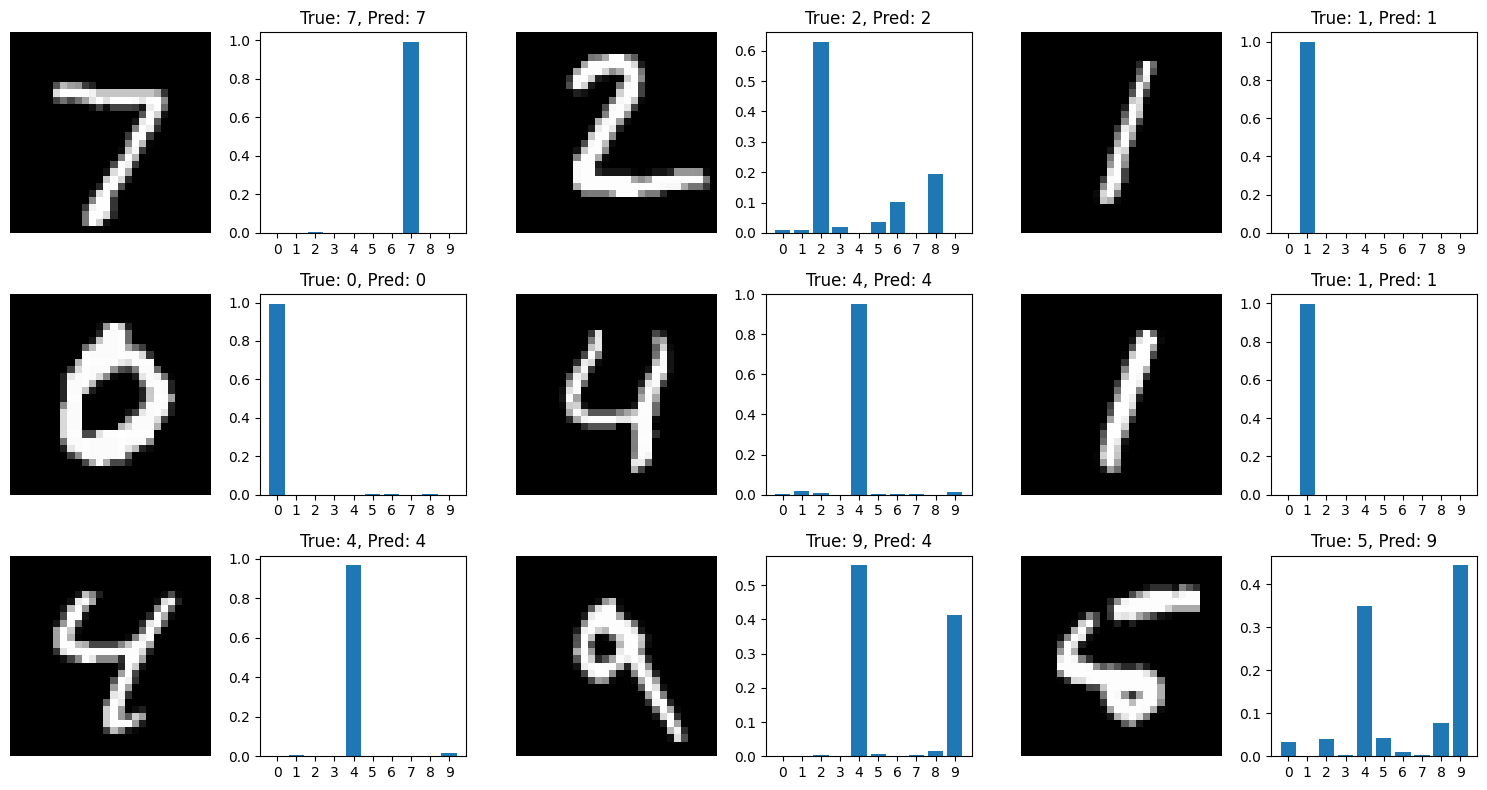

In [17]:
# Get one batch from test_loader
for test_x, test_y in test_loader:
    test_x = test_x.to(device)
    test_y = test_y.to(device)
    pred = vit(test_x)
    pred = pred.softmax(dim=-1)
    break

# Show 9 examples (3 rows, 2 subplots per example → 6 columns)
num_examples = 9
fig, axs = plt.subplots(3, 6, figsize=(15, 8))  # 3 rows, 6 columns

for i in range(num_examples):
    row = i // 3
    col = (i % 3) * 2  # left = image, right = bar chart

    # Image
    axs[row][col].imshow(test_x[i][0].detach().cpu().numpy(), cmap="gray") # remove cmap="gray" to get the yellow/purple colorscheme
    axs[row][col].axis("off")

    # Prediction bar chart
    axs[row][col + 1].bar(np.arange(10), pred[i].detach().cpu().numpy())
    axs[row][col + 1].set_xticks(np.arange(10))
    axs[row][col + 1].set_title(f"True: {test_y[i].item()}, Pred: {pred[i].argmax().item()}")

plt.tight_layout()
plt.show()


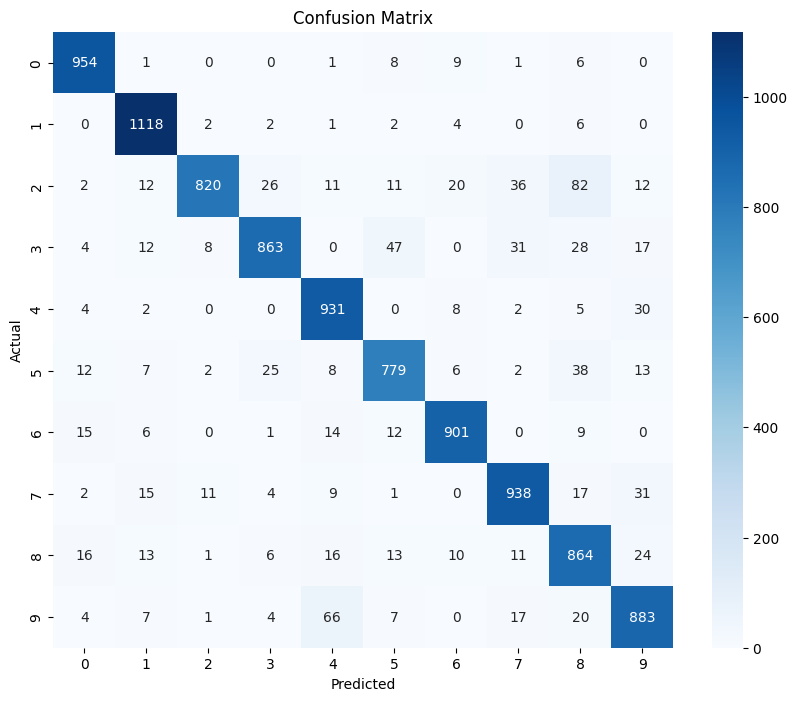

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in data_loader:
            output = model(x)
            _, preds = torch.max(output, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

vit.cpu()

plot_confusion_matrix(vit, test_loader)



torch.Size([256, 1, 28, 28])


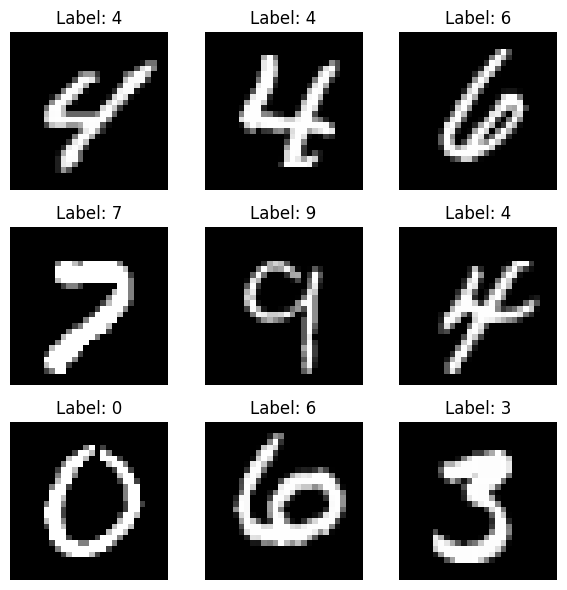

In [13]:
# Prints shape information and a random sample of 9 MNIST 28x28 images
for images, labels in train_loader:
    print(images.shape)  # torch.Size([256, 1, 28, 28])
    break

# Select 9 random indices
indices = random.sample(range(len(images)), 9)

# Create a 3x3 grid plot
fig, axs = plt.subplots(3, 3, figsize=(6, 6))

for i, idx in enumerate(indices):
    row, col = divmod(i, 3)
    img = images[idx].squeeze().cpu().numpy()  # shape: (28, 28)
    label = labels[idx].item()
    
    axs[row][col].imshow(img, cmap='gray')
    axs[row][col].set_title(f"Label: {label}")
    axs[row][col].axis('off')

plt.tight_layout()
plt.show()